In [258]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import datetime
from wrangle import get_connection, get_log_data, new_log_data, get_zillow_data, clean_zillow, missing_zero_values_table

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

<h2>INTRO</h2>

- Before you head down this notebook, please be aware that the work in customer database and zillow pretty much follows the curriculum as I was still trying to understand anomaly detection...so as to say that the work isn't very interesting.

- Now, where I start to get more of a groove in asking questions and opening up the data is in the Log Files. I began to have a better intuition into searching the data and understanding how to investigate an anomaly more fully. While not perfect by any means, I feel like I have a better feel for exploring the data more fully. 

- Visualizations aren't great but I think they can be improved upon in Tableau.

- More features can be added

- All of the null values in the log dataset existed in either those who have a program id of 1 or none at all

- Around 6% of the log entries are null although they do have a user_id & ip address. Could this be a bug?

- Null values might be produced by students who leave the program and have their cohort info erased although the user_id and log info stay put (user_ids aren't reused)

- Doesn't explain why those with a program ID of 1 are having null values pop up though.


-------

<h3> Customer Database </h3>

--------

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.Region.value_counts()


3    316
1     77
2     47
Name: Region, dtype: int64

In [6]:
df.Channel.value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [8]:
# create data frame of columns to scale

df = df[["Frozen", "Detergents_Paper", "Delicassen"]]

In [9]:
df.head()

,Frozen,Detergents_Paper,Delicassen
customer_id,,,
0,214,2674,1338
1,1762,3293,1776
2,2405,3516,7844
3,6404,507,1788
4,3915,1777,5185


In [10]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 214., 2674., 1338.],
       [1762., 3293., 1776.],
       [2405., 3516., 7844.],
       [6404.,  507., 1788.],
       [3915., 1777., 5185.],
       [ 666., 1795., 1451.],
       [ 480., 3140.,  545.],
       [1669., 3321., 2566.],
       [ 425., 1716.,  750.],
       [1159., 7425., 2098.]], dtype=float32)

In [11]:
# scaler

scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605233, 0.16355862],
       [0.1048419 , 0.01234568, 0.03723405],
       [0.063934  , 0.04345483, 0.10809346],
       [0.01053514, 0.04389575, 0.03020442],
       [0.00747814, 0.07684205, 0.0113058 ],
       [0.02701992, 0.08127572, 0.05346267],
       [0.00657419, 0.04196061, 0.01558198],
       [0.01863783, 0.18180482, 0.04370046]], dtype=float32)

esp=1.0


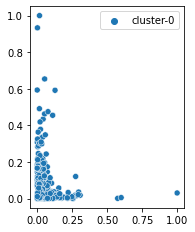

esp=0.5


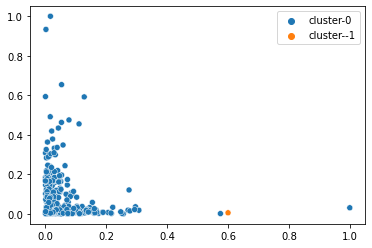

esp=0.3333333333333333


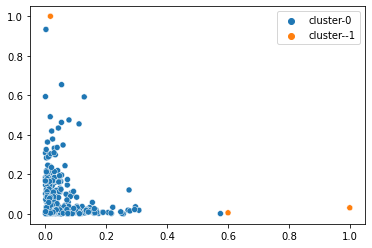

esp=0.25


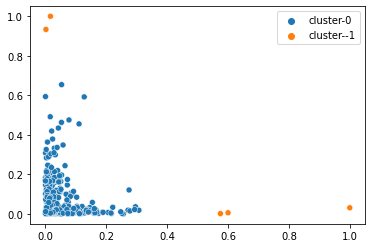

esp=0.2


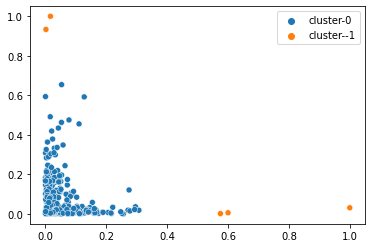

esp=0.16666666666666666


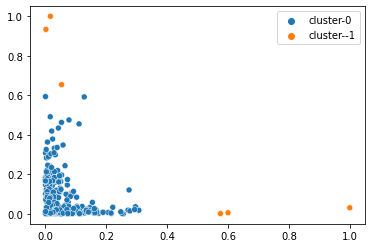

esp=0.14285714285714285


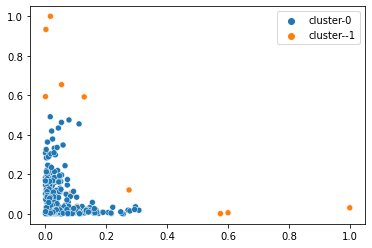

esp=0.125


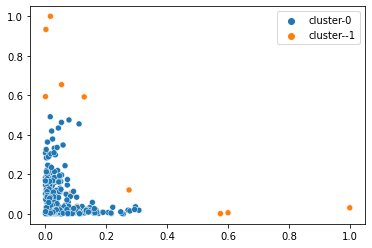

esp=0.1111111111111111


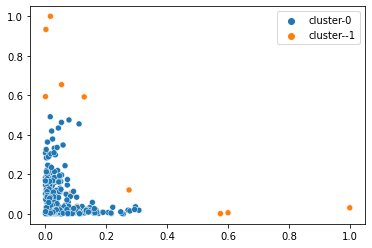

esp=0.1


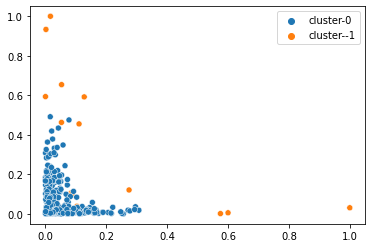

In [12]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=10).fit(np_array)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    
    ax = fig.add_subplot(2, 5, i)
    print(f'esp={eps}')
    sns.scatterplot(np_array[:,0], np_array[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1
    
    
    plt.show()

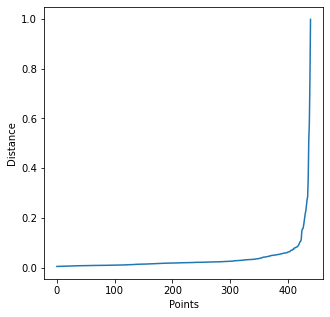

In [13]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(np_array)
distances, indices = neighbors.kneighbors(np_array)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

0.05877263960849928


<Figure size 360x360 with 0 Axes>

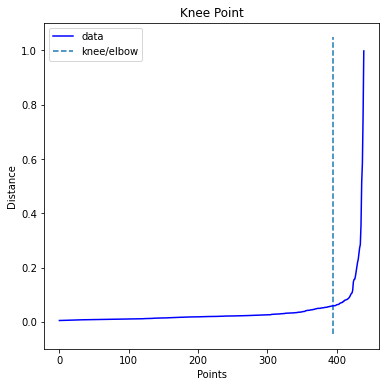

In [14]:
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [15]:
dbsc = DBSCAN(eps = .08, min_samples = 10).fit(np_array)

In [16]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [17]:
df.head()

,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,214,2674,1338,0.003106,0.065427,0.027847
1,1762,3293,1776,0.028548,0.080590,0.036984
2,2405,3516,7844,0.039116,0.086052,0.163559
3,6404,507,1788,0.104842,0.012346,0.037234
4,3915,1777,5185,0.063934,0.043455,0.108093


In [18]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
df['labels'] = labels
df.labels.value_counts()

 0    423
-1     17
Name: labels, dtype: int64

In [20]:
df[df.labels==-1].head()

,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
23,5154,4337,16523,0.084298,0.106163,0.344597,-1
47,7782,24171,6465,0.127490,0.592005,0.134793,-1
56,2616,17740,1340,0.042584,0.434475,0.027889,-1
61,3254,26701,2017,0.053070,0.653978,0.042011,-1
65,36,24231,1423,0.000181,0.593474,0.029620,-1


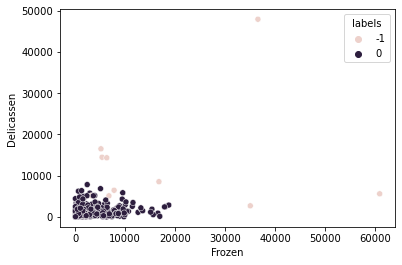

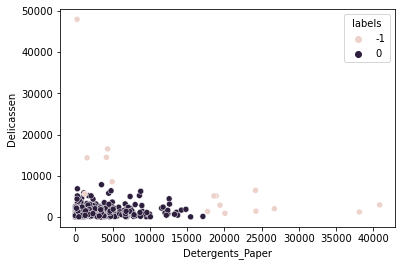

In [21]:
sns.scatterplot(df.Frozen, df.Delicassen, hue=df.labels)
plt.show()


sns.scatterplot(df.Detergents_Paper, df.Delicassen, hue=df.labels)
plt.show()

In [22]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Frozen, df.Detergents_Paper, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Delicassen')



Text(0.5, 0, 'Delicassen')

----------------

<h3> Zillow Database </h3>

-----------------


In [23]:
zillow_df = clean_zillow(df)

In [24]:
zillow_df.head()

,total_sqft,bedroom_quanity,bathroom_quanity,fips,zip_code,year_built,tax_assessed_value,latitude,longitude,property_tax,age_of_home,bath_pers_qft,beds_pers_qft
parcelid,,,,,,,,,,,,,
13083743,1050.0,3.0,2.0,6037,96488,1960,259334.0,34.010864,-117.900894,3345.78,61,0.001905,0.002857
12172334,972.0,2.0,1.0,6037,96292,1926,523000.0,34.169940,-118.115829,6217.88,95,0.001029,0.002058
14373018,1471.0,4.0,2.0,6059,96962,1974,426495.0,33.637276,-117.681098,4505.96,47,0.001360,0.002719
17212473,2758.0,5.0,3.0,6111,96383,1971,474761.0,34.201374,-118.883824,5021.22,50,0.001088,0.001813
12465222,2460.0,3.0,3.0,6037,96241,1952,463120.0,33.825393,-118.194634,5607.88,69,0.001220,0.001220


In [25]:
zillow_df.shape

(39472, 13)

In [26]:
# create data frame of columns to scale

df_z = zillow_df[["total_sqft", "bathroom_quanity", "latitude"]]

In [27]:
df_z.head()

,total_sqft,bathroom_quanity,latitude
parcelid,,,
13083743,1050.0,2.0,34.010864
12172334,972.0,1.0,34.169940
14373018,1471.0,2.0,33.637276
17212473,2758.0,3.0,34.201374
12465222,2460.0,3.0,33.825393


In [28]:
np_array = df_z.values.astype("float32", copy = False)
np_array[0:10]

array([[1.0500000e+03, 2.0000000e+00, 3.4010864e+01],
       [9.7200000e+02, 1.0000000e+00, 3.4169941e+01],
       [1.4710000e+03, 2.0000000e+00, 3.3637276e+01],
       [2.7580000e+03, 3.0000000e+00, 3.4201374e+01],
       [2.4600000e+03, 3.0000000e+00, 3.3825394e+01],
       [2.7220000e+03, 3.0000000e+00, 3.3966038e+01],
       [1.5820000e+03, 2.0000000e+00, 3.3818745e+01],
       [1.1360000e+03, 1.0000000e+00, 3.3814301e+01],
       [4.0220000e+03, 4.0000000e+00, 3.4423622e+01],
       [9.8100000e+02, 2.0000000e+00, 3.4311001e+01]], dtype=float32)

In [29]:
# scaler

scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.04763305, 0.1       , 0.45381355],
       [0.04304616, 0.        , 0.5613575 ],
       [0.07239047, 0.1       , 0.20124626],
       [0.14807409, 0.20000002, 0.58260727],
       [0.13054983, 0.20000002, 0.32842445],
       [0.14595707, 0.20000002, 0.4235077 ],
       [0.07891797, 0.1       , 0.32392883],
       [0.05269038, 0.        , 0.32092476],
       [0.22240517, 0.3       , 0.73286057],
       [0.04357542, 0.1       , 0.6567211 ]], dtype=float32)

In [30]:
dbsc = DBSCAN(eps = .11, min_samples = 2500).fit(np_array)

In [31]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df_z.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = zillow_df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = zillow_df.merge(scaled_df, on=zillow_df.index)
#df = df.drop(columns=['key_0'])

In [32]:
labels = dbsc.labels_
labels[0:]

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
df_z['labels'] = labels
df_z.labels.value_counts()

 0    36546
-1     2926
Name: labels, dtype: int64

In [ ]:
%matplotlib inline

sns.scatterplot(df_z.total_sqft, df_z.bathroom_quanity, hue=df_z.labels)
plt.show()

sns.scatterplot(df_z.latitude, df_z.bathroom_quanity, hue=df_z.labels)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df_z.total_sqft, df_z.latitude, df_z.bathroom_quanity,
           c=df_z.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('total_sqft')
ax.set_ylabel('latitude')
ax.set_zlabel('bathroom_quanity')

In [ ]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
%matplotlib inline
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=750).fit(np_array)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    
    ax = fig.add_subplot(2, 5, i)
    print(f'esp={eps}')
    sns.scatterplot(np_array[:,0], np_array[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1
    
    
    plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(np_array)
distances, indices = neighbors.kneighbors(np_array)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

In [ ]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

--------

# Logs

----

 - Let's investigate log files using anomaly detection

In [34]:

df = get_log_data(cached=True)
    

In [52]:
%matplotlib inline

In [35]:
df.head(1)

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0


In [36]:
df.drop(columns='slack', inplace=True, axis=0)

In [37]:
df.drop(columns='deleted_at', inplace=True, axis=0)

In [38]:
df['date_time'] = df['date'].str.cat(df['time'],sep=" ")

In [39]:
df.date_time = pd.to_datetime(df.date_time)

df = df.set_index('date_time').sort_index()

In [40]:
df['day'] = df.index.day_name()

In [41]:
df['month'] = df.index.month_name()

In [42]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month
date_time,,,,,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Friday,January


<h3>Create a date diff column that takes the date the site was last accessed by the date the individuals program ended</h3>

In [55]:
df['datediff'] =   pd.to_datetime(df.date) - pd.to_datetime(df.end_date)

df['datediff'] / pd.Timedelta(1, unit='d')
df['datediff'].astype('timedelta64[D]')

date_time
2018-01-26 09:55:03     720.0
2018-01-26 09:56:02     720.0
2018-01-26 09:56:05     720.0
2018-01-26 09:56:06     720.0
2018-01-26 09:56:24    -111.0
                        ...  
2021-04-21 16:41:51    2633.0
2021-04-21 16:42:02    2633.0
2021-04-21 16:42:09    2633.0
2021-04-21 16:44:37    2633.0
2021-04-21 16:44:39    2633.0
Name: datediff, Length: 900223, dtype: float64

In [56]:
df.datediff.value_counts()

-57 days     7518
-50 days     6925
-49 days     6897
-105 days    6854
-92 days     6831
             ... 
2118 days       1
1785 days       1
1615 days       1
1243 days       1
1757 days       1
Name: datediff, Length: 2477, dtype: int64

In [59]:
df.groupby('user_id').datediff.value_counts()

user_id  datediff 
1        1980 days    101
         1851 days     73
         843 days      68
         1833 days     66
         1981 days     64
                     ... 
980      2626 days      1
         2631 days      1
981      -137 days     25
         -136 days      9
         -135 days      8
Name: datediff, Length: 72079, dtype: int64

In [64]:
df.groupby(['user_id','name', 'path', 'date', 'end_date','ip']).datediff.value_counts()

user_id  name     path                                    date        end_date    ip             datediff 
1        Hampton  /                                       2018-01-26  2016-02-06  97.105.19.61   720 days      1
                                                          2018-01-30  2016-02-06  97.105.19.61   724 days      1
                                                          2018-02-01  2016-02-06  72.177.226.58  726 days      2
                                                                                  97.105.19.61   726 days      1
                                                          2018-02-02  2016-02-06  97.105.19.61   727 days      1
                                                                                                              ..
981      Neptune  html-css/css-ii/bootstrap-grid-system   2021-04-19  2021-09-03  67.11.98.144   -137 days    13
                                                          2021-04-20  2021-09-03  67.11.98.144   -136 

user_id 1 last accessed the curriculum 

In [74]:
df[df['user_id']== 1].name.value_counts()

Staff      5787
Hampton    1617
Name: name, dtype: int64

In [90]:
df.groupby(['user_id','name', 'path', 'date', 'end_date','ip']).datediff.nunique()

user_id  name     path                                    date        end_date    ip           
1        Hampton  /                                       2018-01-26  2016-02-06  97.105.19.61     1
                                                          2018-01-30  2016-02-06  97.105.19.61     1
                                                          2018-02-01  2016-02-06  72.177.226.58    1
                                                                                  97.105.19.61     1
                                                          2018-02-02  2016-02-06  97.105.19.61     1
                                                                                                  ..
981      Neptune  html-css/css-ii/bootstrap-grid-system   2021-04-19  2021-09-03  67.11.98.144     1
                                                          2021-04-20  2021-09-03  67.11.98.144     1
                                                          2021-04-21  2021-09-03  67.11.98.144  

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype          
---  ------      --------------   -----          
 0   date        900223 non-null  object         
 1   time        900223 non-null  object         
 2   path        900222 non-null  object         
 3   user_id     900223 non-null  int64          
 4   cohort_id   847330 non-null  float64        
 5   ip          900223 non-null  object         
 6   id          847330 non-null  float64        
 7   name        847330 non-null  object         
 8   start_date  847330 non-null  object         
 9   end_date    847330 non-null  object         
 10  created_at  847330 non-null  object         
 11  updated_at  847330 non-null  object         
 12  program_id  847330 non-null  float64        
 13  day         900223 non-null  object         
 14  month       900223 non-null  object         
 15  

<h2>make a data frame where the date diff is greater than or equal to 720 days (that is, their cohort ended at least 2 years ago but they are accessing the site)</h2>

- to do this, will need to create a new column where datediff has been turned into an integer and NaT values have been filled

```df['date_as_int']= df.datediff.astype(int) ```

In [101]:
df.groupby(['path', 'user_id', 'datediff', 'date', 'end_date', 'ip']).name.value_counts(100)

path                              user_id  datediff   date        end_date    ip              name     
%20https://github.com/RaulCPena   580      -81 days   2020-04-17  2020-07-07  74.192.167.159  Curie        1.0
'                                 64       2527 days  2021-01-05  2014-02-04  71.150.217.33   Staff        1.0
,%20https://github.com/RaulCPena  580      -81 days   2020-04-17  2020-07-07  74.192.167.159  Curie        1.0
.git                              203      -105 days  2018-06-28  2018-10-11  72.178.123.71   Voyageurs    1.0
.gitignore                        203      -105 days  2018-06-28  2018-10-11  72.178.123.71   Voyageurs    1.0
                                                                                                          ... 
working-with-time-series-data     692      -80 days   2020-10-24  2021-01-12  96.8.130.213    Darden       1.0
                                  695      -78 days   2020-10-26  2021-01-12  162.197.239.66  Darden       1.0
        

In [102]:
df.name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Darden        32015
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Bayes         26538
Wrangell      25586
Andromeda     25359
Kalypso       23691
Curie         21582
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Easley        14715
Lassen         9587
Arches         8890
Florence       8562
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: name, dtype: int64

<h4> Any cohort that has less than 3,000 log counts is worth looking into </h4>

---

Create a column called 'is_ds' to denote the data science cohorts from those that are not

- program id does this in an ordinal way but I wanted to make a feature

In [105]:
df['is_ds'] = df['name'].apply(lambda x: 1 if x == 'Bayes' or x == 'Curie' or x == 'Darden' or x == 'Easley' or x == 'Florence' else '0')

In [129]:
df.loc[df.is_ds == 1, 'path'].value_counts()

/                                           8358
search/search_index.json                    2203
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg        1651
                                            ... 
5-stats/4.2-compare-means/null                 1
2-storytelling/chart-types                     1
appendix/git/cli                               1
12-distributed-ml/6.3-prepare-part-3           1
ml-methodologies-drawing.jpg                   1
Name: path, Length: 682, dtype: int64

In [212]:
df[df['user_id']== 581].name.value_counts()

Curie    3473
Staff    2961
Name: name, dtype: int64

In [245]:
df.loc[df.user_id == 405, 'path'].value_counts()

11._DistributedML                        1
Exercises                                1
2.02.00_Inferential_Stats                1
Appendix_Tidy_Data                       1
AnomalyDetectionCartoon.jpeg             1
2.00.02_Navigating_Excel                 1
8.1_Overview                             1
9.1_About                                1
3.9-temporary-tables                     1
/                                        1
12.01_SocialNetworkAnalysis              1
4.6.4_introduction_to_seaborn            1
2.00.05_Charts_PivotTables_Sparklines    1
Name: path, dtype: int64

In [242]:
df.user_id.value_counts().head(15)

11     17913
64     16347
53     12329
314     7783
1       7404
495     6451
581     6434
428     5897
344     5460
248     5075
570     4584
315     4510
211     4227
423     3804
555     3687
Name: user_id, dtype: int64

In [154]:
df.groupby('name').agg({'user_id': ['size']})

,user_id
,size
name,
Andromeda,25359
Apex,33568
Apollo,5
Arches,8890
Badlands,93
Bash,17713
Bayes,26538
Betelgeuse,29356


<h3>Takeaways</h3>

 - There are several cohorts that have low log counts. These seem to be outside the traditional web_dev/DS cohorts
 - These were early programs
 - There is one user who went through the LAMP/J stack program in 2015. That person appeared to be accessing data science material in May of 2019. Their information is below

In [240]:
df[df['name']== 'Franklin'].tail()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2019-05-12 21:40:23,2019-05-12,21:40:23,9.1_About,405,6.0,136.49.177.117,6.0,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Sunday,May,1447 days,0
2019-05-12 21:40:23,2019-05-12,21:40:23,AnomalyDetectionCartoon.jpeg,405,6.0,136.49.177.117,6.0,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Sunday,May,1447 days,0
2019-05-12 21:40:35,2019-05-12,21:40:35,11._DistributedML,405,6.0,136.49.177.117,6.0,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Sunday,May,1447 days,0
2019-05-12 21:40:40,2019-05-12,21:40:40,12.01_SocialNetworkAnalysis,405,6.0,136.49.177.117,6.0,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Sunday,May,1447 days,0
2019-05-12 21:40:52,2019-05-12,21:40:52,Appendix_Tidy_Data,405,6.0,136.49.177.117,6.0,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Sunday,May,1447 days,0


<h4>Why is user 405 accessing what appears to be early data science material when this user went through the php program nearly 4 years previous</h4>

In [238]:
df[df['user_id']== 405].path.value_counts()

11._DistributedML                        1
Exercises                                1
2.02.00_Inferential_Stats                1
Appendix_Tidy_Data                       1
AnomalyDetectionCartoon.jpeg             1
2.00.02_Navigating_Excel                 1
8.1_Overview                             1
9.1_About                                1
3.9-temporary-tables                     1
/                                        1
12.01_SocialNetworkAnalysis              1
4.6.4_introduction_to_seaborn            1
2.00.05_Charts_PivotTables_Sparklines    1
Name: path, dtype: int64

In [302]:
df[df['path']== '11._DistributedML'].tail()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2019-05-12 21:40:35,2019-05-12,21:40:35,11._DistributedML,405,6.0,136.49.177.117,6.0,Franklin,2015-02-03,2015-05-26,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Sunday,May,1447 days,0
2019-05-13 07:14:22,2019-05-13,07:14:22,11._DistributedML,352,NaN,99.203.27.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,May,NaT,0
2019-05-13 09:08:40,2019-05-13,09:08:40,11._DistributedML,351,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,May,NaT,0
2019-05-13 16:15:39,2019-05-13,16:15:39,11._DistributedML,349,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,May,NaT,0
2019-05-14 09:59:12,2019-05-14,09:59:12,11._DistributedML,357,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,May,NaT,0


-----

<h4> More users appear to be accessing early data science material although there are nulls present, could be a bug?</h4>

-----

In [303]:
df[df['path']== '4.6.4_introduction_to_seaborn'].tail()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2019-06-17 17:07:32,2019-06-17,17:07:32,4.6.4_introduction_to_seaborn,53,14.0,67.10.174.56,14.0,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Monday,June,949 days,0
2019-06-18 08:49:52,2019-06-18,08:49:52,4.6.4_introduction_to_seaborn,404,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Tuesday,June,1960 days,0
2019-06-18 09:09:30,2019-06-18,09:09:30,4.6.4_introduction_to_seaborn,404,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Tuesday,June,1960 days,0
2019-06-18 14:30:28,2019-06-18,14:30:28,4.6.4_introduction_to_seaborn,404,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Tuesday,June,1960 days,0
2019-06-21 14:13:53,2019-06-21,14:13:53,4.6.4_introduction_to_seaborn,362,NaN,70.123.200.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friday,June,NaT,0


-----

<h4>Why are non-ds students accessing seaborn material?</h4>

- Are null students those who dropped out or didn't make grades?

-----

In [305]:
df.loc[df['user_id'] == 372].head()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2019-03-11 17:54:08,2019-03-11,17:54:08,/,372,NaN,72.181.105.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,March,NaT,0
2019-03-11 17:54:14,2019-03-11,17:54:14,4.6.1_introduction_to_matplotlib,372,NaN,72.181.105.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday,March,NaT,0
2019-03-12 09:58:51,2019-03-12,09:58:51,4.6.1_introduction_to_matplotlib,372,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,March,NaT,0
2019-03-12 11:22:10,2019-03-12,11:22:10,4.6.2_introduction_to_numpy,372,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,March,NaT,0
2019-03-13 10:53:31,2019-03-13,10:53:31,4.6.3_introduction_to_pandas,372,NaN,97.105.19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,March,NaT,0


In [255]:
df.loc[df['user_id'] == 372].path.value_counts()

/                           52
search/search_index.json    33
6_Exercises                 22
7_Exercises                 19
Regression_Python           18
                            ..
BuiltIn_Datasets             1
Classification_DataPrep      1
3.3-tables                   1
10.03_Explore                1
javascript-i/mapbox-api      1
Name: path, Length: 223, dtype: int64

In [256]:
df.loc[df['user_id'] == 372].ip.value_counts()

97.105.19.58       485
72.181.105.81      352
192.171.117.210     26
70.94.160.224        2
104.55.228.222       2
Name: ip, dtype: int64

In [259]:
missing_zero_values_table(df)

Your selected dataframe has 17 columns and 900223 Rows.
There are 10 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
start_date,0,52893,5.9,52893,5.9,object
program_id,0,52893,5.9,52893,5.9,float64
datediff,0,52893,5.9,52893,5.9,timedelta64[ns]
cohort_id,0,52893,5.9,52893,5.9,float64
id,0,52893,5.9,52893,5.9,float64
name,0,52893,5.9,52893,5.9,object
end_date,0,52893,5.9,52893,5.9,object
created_at,0,52893,5.9,52893,5.9,object
updated_at,0,52893,5.9,52893,5.9,object
path,0,1,0.0,1,0.0,object


- create a dataframe where the only values held are those where program id equals 1 or null. Want to find out if all nulls live within here


In [278]:
null_df = df[(df['program_id']!= 2) & (df['program_id']!= 3) & (df['program_id']!= 4)]

In [285]:
null_df.tail()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2021-04-21 12:49:00,2021-04-21,12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,April,NaT,0
2021-04-21 12:49:02,2021-04-21,12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,April,NaT,0
2021-04-21 12:51:27,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,April,NaT,0
2021-04-21 12:52:37,2021-04-21,12:52:37,javascript-ii/promises,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,April,NaT,0
2021-04-21 12:56:26,2021-04-21,12:56:26,javascript-ii/RESTful-api,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,April,NaT,0


In [280]:
missing_zero_values_table(null_df)

Your selected dataframe has 17 columns and 83441 Rows.
There are 9 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
start_date,0,52893,63.4,52893,63.4,object
updated_at,0,52893,63.4,52893,63.4,object
datediff,0,52893,63.4,52893,63.4,timedelta64[ns]
cohort_id,0,52893,63.4,52893,63.4,float64
id,0,52893,63.4,52893,63.4,float64
name,0,52893,63.4,52893,63.4,object
program_id,0,52893,63.4,52893,63.4,float64
end_date,0,52893,63.4,52893,63.4,object
created_at,0,52893,63.4,52893,63.4,object
month,0,0,0.0,0,0.0,object


In [290]:
null_df.groupby('user_id').ip.value_counts()

user_id  ip            
1        97.105.19.61      1016
         97.105.19.58       338
         72.177.226.58      242
         172.56.15.15         8
         72.177.229.125       4
                           ... 
815      162.211.70.252       2
         67.172.2.121         2
         70.121.197.121       2
852      172.5.98.128         2
952      70.125.158.82        1
Name: ip, Length: 857, dtype: int64

In [295]:
df.loc[df['user_id'] == 815]

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2020-11-18 11:06:57,2020-11-18,11:06:57,/,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:07:42,2020-11-18,11:07:42,classification/overview,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:07:42,2020-11-18,11:07:42,classification/scale_features_or_not.svg,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:15:03,2020-11-18,11:15:03,classification/acquire,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:17:19,2020-11-18,11:17:19,classification/prep,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:19:29,2020-11-18,11:19:29,classification/tidy-data,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:26:57,2020-11-18,11:26:57,classification/acquire,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:29:51,2020-11-18,11:29:51,classification/overview,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0
2020-11-18 11:29:51,2020-11-18,11:29:51,classification/scale_features_or_not.svg,815,NaN,216.177.165.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,November,NaT,0


- Why is someone with and an 800 number user id producing nulls?
- They were accessing DS material and accessed the site as late as April 5, 2021
- Multiple IP addresses, most in Boerne but one did read in Arkansas
- I think null values are being produced by students who are no longer active. 


<AxesSubplot:>

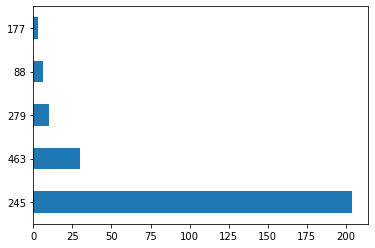

In [268]:
df[df['name'] == "Ike"].user_id.value_counts().plot(kind='barh')

In [272]:
df.loc[df['name'] == 'Franklin'].program_id.value_counts()

1.0    72
Name: program_id, dtype: int64

- The php program seems to have a lot of issues will null values and missing data

In [296]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,start_date,end_date,created_at,updated_at,program_id,day,month,datediff,is_ds
date_time,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January,720 days,0
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January,720 days,0
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January,720 days,0
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Friday,January,720 days,0
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Friday,January,-111 days,0
